In [272]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .master("local[*]") \
    .config("spark.driver.memory", "15g") \
    .appName("MelbournePedistrian") \
    .getOrCreate()

sc = spark.sparkContext

In [273]:
import math

train_part_num = 3
test_part_num = 3
k = 7
in_k = max(math.floor(k/train_part_num), 1)

In [274]:
from pyspark.sql.types import *
from pyspark.sql.functions import col, mean, stddev
from pyspark.sql.functions import col, isnan, when, count

def load_and_preprocess(train_path, test_path):
    schema = StructType([
        StructField("Class", StringType(), True),
        StructField("0hr", FloatType(), True),
        StructField("1hr", FloatType(), True),
        StructField("2hr", FloatType(), True),
        StructField("3hr", FloatType(), True),
        StructField("4hr", FloatType(), True),
        StructField("5hr", FloatType(), True),
        StructField("6hr", FloatType(), True),
        StructField("7hr", FloatType(), True),
        StructField("8hr", FloatType(), True),
        StructField("9hr", FloatType(), True),
        StructField("10hr", FloatType(), True),
        StructField("11hr", FloatType(), True),
        StructField("12hr", FloatType(), True),
        StructField("13hr", FloatType(), True),
        StructField("14hr", FloatType(), True),
        StructField("15hr", FloatType(), True),
        StructField("16hr", FloatType(), True),
        StructField("17hr", FloatType(), True),
        StructField("18hr", FloatType(), True),
        StructField("19hr", FloatType(), True),
        StructField("20hr", FloatType(), True),
        StructField("21hr", FloatType(), True),
        StructField("22hr", FloatType(), True),
        StructField("23hr", FloatType(), True)
    ])
    train_df = spark.read.format("csv").option("delimiter", "\t").schema(schema).load(train_path)
    test_df = spark.read.format("csv").option("delimiter", "\t").schema(schema).load(test_path)

    from pyspark.sql.functions import rand

    train_df = train_df.orderBy(rand(seed=42))
    test_df = test_df.orderBy(rand(seed=42))

    merged_df = train_df.union(test_df)

    # Replace NaN values
    for column in merged_df.columns[1:]:
        median = merged_df.approxQuantile(column, [0.5], 0.25)[0]
        merged_df = merged_df.na.fill(median, [column])

    return merged_df

In [275]:
merged_df = load_and_preprocess(
    "../data/MelbournePedestrian/MelbournePedestrian_TRAIN.tsv", 
    "../data/MelbournePedestrian/MelbournePedestrian_TEST.tsv"
    )

# Show the resulting dataframe
merged_df.count()

3633

In [276]:
merged_df = merged_df.limit(1000)

In [277]:
merged_df.show(5)

+-----+-----+----+----+----+----+-----+-----+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+-----+
|Class|  0hr| 1hr| 2hr| 3hr| 4hr|  5hr|  6hr|   7hr|   8hr|   9hr|  10hr|  11hr|  12hr|  13hr|  14hr|  15hr|  16hr|  17hr|  18hr|  19hr|  20hr|  21hr|  22hr| 23hr|
+-----+-----+----+----+----+----+-----+-----+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+-----+
|    3|  8.0| 8.0| 4.0| 5.0| 0.0|  2.0| 24.0|  53.0| 100.0|  68.0|  62.0|  97.0| 186.0| 151.0| 146.0| 119.0| 186.0| 239.0| 221.0| 151.0| 121.0|  61.0|  31.0| 28.0|
|    3| 16.0| 3.0| 1.0| 2.0| 7.0| 12.0| 45.0| 169.0| 244.0| 168.0| 145.0| 162.0| 340.0| 303.0| 184.0| 179.0| 188.0| 278.0| 256.0| 160.0| 110.0|  81.0|  75.0| 33.0|
|    6|216.0|75.0|51.0|31.0|15.0| 37.0| 86.0| 317.0| 391.0| 541.0| 699.0|1029.0|1374.0|1365.0|1546.0|1573.0|1495.0|1495.0|1710.0| 870.0| 715.0| 559.0|1015.0|497.0|
|    4|150.0|46.

In [278]:
# Define the split ratio
train_ratio = 0.7
test_ratio = 0.3

# Split the data into train and test sets
train_df, test_df = merged_df.randomSplit([train_ratio, test_ratio], seed=346)

In [279]:
train_df.groupBy("Class").count().show()

+-----+-----+
|Class|count|
+-----+-----+
|    3|  248|
|   10|  263|
|    4|  258|
|    7|  264|
|    5|  262|
|    1|  260|
|    2|  264|
|    6|  259|
|    9|  255|
|    8|  245|
+-----+-----+



In [280]:
train_df.count()

2578

In [281]:
# train_df.cache()
# test_df.cache()

In [282]:
# for df in [train_df, test_df]:
#     duplicates_df = df.dropDuplicates()
#     num_duplicates = df.count() - duplicates_df.count()
#     if num_duplicates > 0:
#         print("There are duplicate rows in the DataFrame.")
#     else:
#         print("There are no duplicate rows in the DataFrame.")

In [283]:
import pyspark.sql.functions as F
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import pandas as pd

In [284]:
from pyspark.sql.functions import array, col, lit

# Determine the number of columns in each partition
num_cols = len(train_df.columns) - 1 # excluding 'Class'
cols_per_part = num_cols // train_part_num
cols_remainder = num_cols % train_part_num

print("TOTAL COLS NUM:", num_cols)
print("COLUMNS PER PARTITION:", cols_per_part)
print("REMAINDER:", cols_remainder)

# Split the columns into equal subsets
col_subsets = []
start_idx = 1
for i in range(train_part_num):
    # Determine the number of columns in this partition
    if i < cols_remainder:
        num_part_cols = cols_per_part + 1
    else:
        num_part_cols = cols_per_part

    print("PARTITION", i, "HAS", num_part_cols, "COLUMNS")

    # Select the columns for this partition and add the 'Class' column
    partition_cols = train_df.columns[start_idx:start_idx+num_part_cols] + ['Class']
    col_subsets.append(partition_cols)

    # Update the starting index for the next partition
    start_idx += num_part_cols

# Split the original dataframe into multiple dataframes
dfs = []
for n, subset in enumerate(col_subsets):
    partition_ids = [4,1,23]
    df = train_df.select(subset)
    for i, column in enumerate(df.columns):
        df = df.withColumnRenamed(column, col_subsets[0][i])
    df = df.withColumn('partition_id', lit(partition_ids[n]))
    dfs.append(df)

# Vertically stack the dataframes to create a single dataframe
result = dfs[0]
for i in range(1, len(dfs)):
    result = result.unionByName(dfs[i])

result.groupBy("partition_id").count().show()

# Partition the DataFrame by the 'partition_id' column
train_df_part = result.repartition(train_part_num, "partition_id")

TOTAL COLS NUM: 24
COLUMNS PER PARTITION: 8
REMAINDER: 0
PARTITION 0 HAS 8 COLUMNS
PARTITION 1 HAS 8 COLUMNS
PARTITION 2 HAS 8 COLUMNS


+------------+-----+
|partition_id|count|
+------------+-----+
|           4| 2578|
|           1| 2578|
|          23| 2578|
+------------+-----+



In [285]:
train_rdd = train_df_part.rdd

# Check the number of partitions
num_partitions = train_rdd.getNumPartitions()
print(f"Number of partitions: {num_partitions}")

# Check the shape of each partition
partition_shapes = train_rdd.mapPartitions(lambda iterator: [len(list(iterator))]).collect()
print(f"Shape of each partition: {partition_shapes}")

Number of partitions: 3
Shape of each partition: [2578, 2578, 2578]


In [286]:
column_names = train_df_part.columns
def toPandas_partition(instances):

    panda_df = pd.DataFrame(columns = column_names)      # using the global variable
    
    for instance in instances:  # each instance is of Row type
        panda_df = pd.concat([panda_df, pd.DataFrame([instance.asDict()])], ignore_index=True)
  
    return [panda_df]

rdd_pandas = train_rdd.mapPartitions(toPandas_partition)

In [287]:
import random
from tslearn.neighbors import KNeighborsTimeSeriesClassifier

def build_model(partition):

    knn = KNeighborsClassifier(n_neighbors=in_k, metric='euclidean')
    
    X_train = partition.drop('Class', axis=1)
    y_train = partition['Class']
    
    model = knn.fit(X_train, y_train)

    return (model, partition['partition_id'][0])

model_list = rdd_pandas.map(build_model).collect()

In [288]:
# Determine the number of columns in each partition
num_cols = len(test_df.columns) - 1 # excluding 'Class'
cols_per_part = num_cols // test_part_num
cols_remainder = num_cols % test_part_num

# print("TOTAL COLS NUM:", num_cols)
# print("COLUMNS PER PARTITION:", cols_per_part)
# print("REMAINDER:", cols_remainder)

# Split the columns into equal subsets
col_subsets = []
start_idx = 1
for i in range(test_part_num):
    # Determine the number of columns in this partition
    if i < cols_remainder:
        num_part_cols = cols_per_part + 1
    else:
        num_part_cols = cols_per_part

    # print("PARTITION", i, "HAS", num_part_cols, "COLUMNS")

    # Select the columns for this partition and add the 'Class' column
    partition_cols = test_df.columns[start_idx:start_idx+num_part_cols] + ['Class']
    col_subsets.append(partition_cols)

    # Update the starting index for the next partition
    start_idx += num_part_cols

# Split the original dataframe into multiple dataframes
dfs = []
for n, subset in enumerate(col_subsets):
    partition_ids = [4,1,23]
    df = test_df.select(subset)
    for i, column in enumerate(df.columns):
        df = df.withColumnRenamed(column, col_subsets[0][i])
    df = df.withColumn('partition_id', lit(partition_ids[n]))
    dfs.append(df)

# Vertically stack the dataframes to create a single dataframe
result = dfs[0]
for i in range(1, len(dfs)):
    result = result.unionByName(dfs[i])

result.groupBy("partition_id").count().show()

# Partition the DataFrame by the 'partition_id' column
test_df_part = result.repartition(test_part_num, "partition_id")

+------------+-----+
|partition_id|count|
+------------+-----+
|           4| 1055|
|           1| 1055|
|          23| 1055|
+------------+-----+



In [289]:
test_rdd = test_df_part.rdd

# Check the number of partitions
num_partitions = test_rdd.getNumPartitions()
print(f"Number of partitions: {num_partitions}")

# Check the shape of each partition
partition_shapes = test_rdd.mapPartitions(lambda iterator: [len(list(iterator))]).collect()
print(f"Shape of each partition: {partition_shapes}")

Number of partitions: 3
Shape of each partition: [1055, 1055, 1055]


In [290]:
test_rdd_pandas = test_rdd.mapPartitions(toPandas_partition)

In [291]:
# Convert RDD to Pandas DataFrame
test_df_pandas = pd.concat(test_rdd_pandas.collect())

# Print the dimensions and shape/size of the Pandas DataFrame
print("Dimensions:", test_df_pandas.ndim)
print("Shape/Size:", test_df_pandas.shape)

# Show the column names in the Pandas DataFrame
print("Column names:", test_df_pandas.columns)

Dimensions: 2
Shape/Size: (3165, 10)
Column names: Index(['0hr', '1hr', '2hr', '3hr', '4hr', '5hr', '6hr', '7hr', 'Class',
       'partition_id'],
      dtype='object')


In [292]:
def test_classifier(partition):
    predictions = []
    distances = []
    X_test = partition.drop('Class', axis=1)
    for m in model_list:
        if m[1] == partition['partition_id'][0]:
            _, neighbors = m[0].kneighbors(X_test)
            pred = m[0].predict(X_test).tolist()
            distances.append(neighbors.tolist())
            predictions.append(pred)

    return list(zip(predictions[0], distances[0]))

partition_predictions = test_rdd_pandas.map(test_classifier)

zipped = list(zip(*partition_predictions.collect()))
cur_k = int(k/len(zipped[0][0][1]))
rdd = sc.parallelize(zipped)
rdd1 = rdd.map(lambda x: sorted(x, key=lambda x: x[1][0], reverse=False)[:cur_k])

from collections import Counter

rdd2 = rdd1.map(lambda x: Counter([t[0] for t in x]).most_common(1)[0][0])

In [293]:
y_pred = rdd2.collect()

In [294]:
len(y_pred)

1055

In [295]:
y_pred

['6',
 '8',
 '3',
 '7',
 '3',
 '9',
 '9',
 '10',
 '2',
 '6',
 '10',
 '10',
 '9',
 '5',
 '6',
 '6',
 '2',
 '2',
 '3',
 '1',
 '7',
 '2',
 '7',
 '4',
 '5',
 '10',
 '4',
 '7',
 '6',
 '2',
 '7',
 '3',
 '1',
 '3',
 '8',
 '9',
 '8',
 '2',
 '3',
 '4',
 '9',
 '8',
 '6',
 '1',
 '5',
 '7',
 '10',
 '5',
 '4',
 '2',
 '7',
 '9',
 '3',
 '4',
 '8',
 '5',
 '7',
 '5',
 '9',
 '1',
 '1',
 '4',
 '4',
 '3',
 '2',
 '6',
 '6',
 '2',
 '5',
 '6',
 '8',
 '6',
 '8',
 '1',
 '2',
 '3',
 '3',
 '8',
 '3',
 '4',
 '5',
 '7',
 '10',
 '4',
 '10',
 '9',
 '3',
 '4',
 '7',
 '2',
 '2',
 '9',
 '4',
 '6',
 '1',
 '3',
 '4',
 '9',
 '1',
 '2',
 '4',
 '4',
 '8',
 '3',
 '8',
 '10',
 '10',
 '4',
 '5',
 '5',
 '1',
 '10',
 '2',
 '8',
 '2',
 '2',
 '2',
 '1',
 '7',
 '8',
 '4',
 '9',
 '2',
 '3',
 '4',
 '5',
 '2',
 '7',
 '4',
 '10',
 '4',
 '8',
 '5',
 '4',
 '2',
 '5',
 '8',
 '10',
 '3',
 '3',
 '7',
 '5',
 '9',
 '10',
 '4',
 '3',
 '4',
 '8',
 '2',
 '8',
 '5',
 '9',
 '1',
 '2',
 '5',
 '8',
 '1',
 '4',
 '2',
 '8',
 '8',
 '6',
 '5',
 '4',
 '9

In [296]:
y_test = test_df.select("Class").collect()

In [297]:
from pyspark.sql.functions import when, count

y_pred_df = spark.createDataFrame([(i,) for i in y_pred], ['prediction'])
y_test_df = spark.createDataFrame(y_test, ['Class'])

In [298]:
from pyspark.sql.functions import monotonically_increasing_id

y_pred_df = y_pred_df.withColumn("id", monotonically_increasing_id())
y_test_df = y_test_df.withColumn("id", monotonically_increasing_id())

joined_df = y_pred_df.join(y_test_df, "id", "outer").drop("id")

joined_df = joined_df.withColumn('same_values', when(joined_df.prediction == joined_df.Class, 1).otherwise(0))

print("joined_df:")
joined_df.show(5)

joined_df:
+----------+-----+-----------+
|prediction|Class|same_values|
+----------+-----+-----------+
|         6|    6|          1|
|         8|    8|          1|
|         3|    3|          1|
|         7|    7|          1|
|         3|    8|          0|
+----------+-----+-----------+
only showing top 5 rows



In [299]:
joined_df.groupBy("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         7|  100|
|         3|  124|
|         8|   96|
|         5|  108|
|         6|   94|
|         9|   99|
|         1|  113|
|        10|  105|
|         4|  104|
|         2|  112|
+----------+-----+



In [300]:
percentage_same_values = joined_df.agg({'same_values': 'mean'}).collect()[0][0] * 100

print(f"{percentage_same_values:.2f}% of rows have the same label and prediction.")

93.74% of rows have the same label and prediction.


In [301]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import col

indexed_df = joined_df.withColumn("ClassIndex", col("Class").cast("integer"))

# Cast the prediction column to DoubleType
indexed_df = indexed_df.withColumn("prediction", col("prediction").cast("double"))

# Compute F1 score
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="ClassIndex", metricName="f1")
f1_score = evaluator.evaluate(indexed_df)
print(f"F1 score: {f1_score:.2f}")

F1 score: 0.94


In [302]:
from pyspark.sql.functions import when
from pyspark.ml.feature import StringIndexer
from pyspark.mllib.evaluation import MulticlassMetrics
import matplotlib.pyplot as plt

indexed_df = indexed_df.withColumn("ClassIndexDb", col("ClassIndex").cast("double"))

In [303]:
# Calculate the confusion matrix
predictions_and_labels = indexed_df.select(["prediction", "ClassIndexDb"]).rdd
metrics = MulticlassMetrics(predictions_and_labels)

confusion_matrix = metrics.confusionMatrix().toArray()

# Define list of class labels
classes = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

/Users/filip/miniconda3/envs/big2/lib/python3.9/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


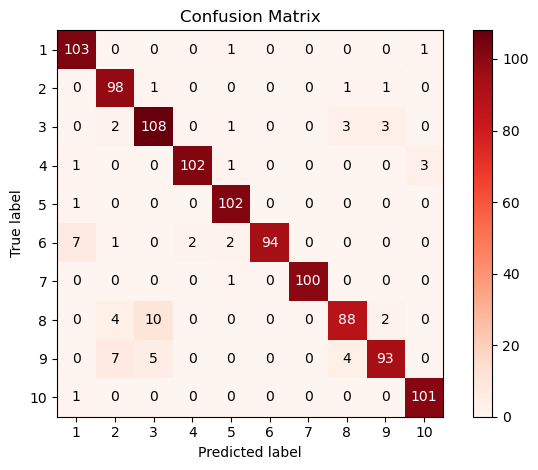

In [304]:
# Plot the confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(confusion_matrix, cmap='Reds')

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Set ticks and tick labels
ax.set_xticks(range(len(classes)))
ax.set_yticks(range(len(classes)))
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)

# Loop over data dimensions and create text annotations.
thresh = confusion_matrix.max() / 2.
for i in range(len(confusion_matrix)):
    for j in range(len(confusion_matrix[i])):
        ax.text(j, i, format(confusion_matrix[i, j], '.0f'),
                ha="center", va="center",
                color="white" if confusion_matrix[i, j] > thresh else "black")

ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
fig.tight_layout()
plt.show()